In [107]:
import numpy as np
import scipy.signal
import sounddevice as sd
%matplotlib inline
from pylab import *
import matplotlib.figure
import itertools
import random
import mpld3
from scipy import stats
mpld3.enable_notebook()
rcParams['figure.figsize'] = 10, 6
rcParams['figure.dpi'] = 90

# initialize signal
signal = np.array([random.randint(0,1) for i in range(8000)])

In [112]:
size_of_packet = int(len(signal) / num_of_packets)
num_of_packets = 10
assert len(signal) % size_of_packet == 0

chunks = [ [] for _ in range(num_of_packets) ]

for i in range(num_of_packets):
    chunks[i] = np.array(signal[i*size_of_packet:(i+1)*size_of_packet],'uint8')

In [126]:
# BEC ERROR CORRECTION    
def rho(d, K):
    if d == 0:
        return 0
    elif d == 1:
        return 1/K
    else: 
        return 1/(d * (d-1))
    
def tau(d, K, c, delta):
    S = c * np.log(K/delta) * np.sqrt(K)
    if d == 0:
        return 0
    elif d == K/S:
        return (S/K) * np.log(S/delta)
    elif d > K/S:
        return 0
    else:
        return (S/K) * (1/d)

def robust_dist(num_chunks, c=0.33, delta=0.39):
    z = sum([rho(d,num_chunks) + tau(d, num_chunks, c, delta) \
            for d in range(num_chunks)])
    xk = np.arange(num_chunks)
    pk = [(rho(d, num_chunks) + tau(d, num_chunks, c, delta))/z \
        for d in range(num_chunks)] 
    return stats.rv_discrete(name='robust', values=(xk,pk))


class Transmitter:
   
    def __init__(self, chunks, channel):
        self.chunks = chunks
        self.num_chunks = len(chunks)
        self.channel = channel
        self.robust = robust_dist(self.num_chunks, 0.5, 0.25)
        
    def generate_new_packet(self):
#         n_of_chunks = random.randint(1,min(5, self.num_chunks))
        n_of_chunks = self.robust.rvs(size=1)[0]
        chunk_indices = random.sample(range(self.num_chunks), n_of_chunks)
        chunks = [ self.chunks[x] for x in chunk_indices ]
        
        # xor data
        data = np.zeros(len(chunks[0]),'uint8')
        for c in chunks:
            data = np.bitwise_xor(data, c)
        
        # label signal with indices
        packet_string = np.zeros(num_of_packets)
        for i in chunk_indices:
            packet_string[i] = 1
        
        return np.concatenate([packet_string, data])
        
    def transmit_one_packet(self):
        packet = self.generate_new_packet()
        self.channel.enqueue( packet )

class Channel:
    def __init__(self, p):
        self.p = p
        self.current_packet = None
        
    def enqueue(self, packet):
        if random.random() < self.p:
            self.current_packet = None
        else:
            self.current_packet = packet
            
    def dequeue(self):
        return self.current_packet
    
class Receiver:
    def __init__(self, num_chunks, channel):
        self.num_chunks = num_chunks
        self.received_packets_indices = []
        self.received_packets_data = []
        self.chunks = []
        for i in range(self.num_chunks):
            self.chunks.append(np.zeros(Packet.size_of_packet, 'uint8') )
        self.found = [ False for x in range(self.num_chunks) ]
        self.channel = channel
        
    def receive_packet(self):
        packet = self.channel.dequeue()
        if packet is not None:
            #num_of_packets is global
            chunk_indices = [index for index,val in enumerate(packet[:num_of_packets]) if val == 1]
            data = packet[num_of_packets:]

            for idx in chunk_indices[:]:
                if self.found[idx]:
                    chunk_indices.remove(idx)
                    data = np.bitwise_xor(data, self.chunks[idx])
            if len(packet) == 1:
                packet_idx = chunk_indices[0]
                self.found[packet_idx] = True
                self.chunks[packet_idx] = data
            elif len(packet) > 1:
                packet_string = np.zeros(num_of_packets)
                for i in chunk_indices:
                    packet_string[i] = 1
                self.received_packets_data.append(data)
                self.received_packets_indices.append(chunk_indices)
                return
            else:
                return
            terminate = False
            if not terminate:
                terminate = True
                for i in len(self.received_packets_data):
                    for idx in chunk_indices[:]:
                        if self.found[idx]:
                            chunk_indices.remove(idx)
                            data = np.bitwise_xor(data, self.chunks[idx])
                    if len(pkt) == 1:
                        packet_idx = chunk_indices[0]
                        self.found[packet_idx] = True
                        self.chunks[packet_idx] = data
                        terminate = False
                        self.received_packets_data.remove(i)
                        self.received_packets_indices.remove(i)
                    elif len(packet) == 0:
                        self.received_packets_data.remove(pkt)
                        self.received_packets_indices.remove(pkt)
             
    def isDone(self):
        return self.chunksDone() == self.num_chunks

    def chunksDone(self):
        return sum(self.found)

In [127]:
p = 0.1
num_trials = 1
ch = Channel(p)
tx_baseline = Transmitter(chunks, ch)
baseline_packets = []
average = 0

for _ in range(num_trials):
    rx = Receiver( len(chunks), ch )
    ct = 0
    while not rx.isDone():
        tx_baseline.transmit_one_packet()
        rx.receive_packet()
        ct += 1 
        baseline_packets.append(sum(rx.found))
    baseline_packets.append(ct)
    average += ct
    
print("The number of packets received: {}".format(average/num_trials))

KeyboardInterrupt: 

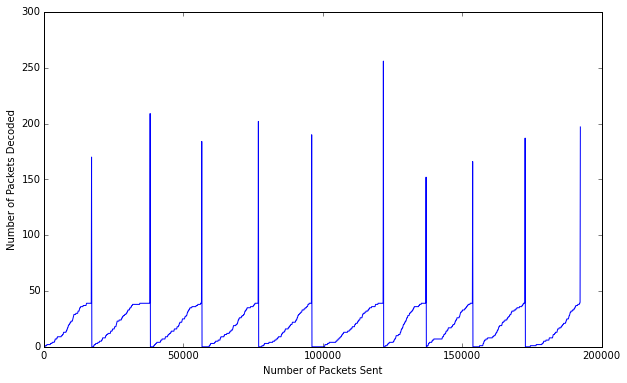

In [88]:
plt.plot(np.arange(len(baseline_packets) + 1) * 100, [0] + baseline_packets)
plt.xlabel("Number of Packets Sent")
plt.ylabel("Number of Packets Decoded")
plt.show()